# Clustering

## Run following clustering algorithms for given fonts
1. K-Means
1. Spectral Clustering
1. Agglomerative
1. Mapper - from homework problem - if time permits

## Imports and Globals

In [22]:
from collections import namedtuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

import font_utils.load_font as LF
import font_utils.upper_lower_numerals as ULN
import plot_utils.plot_font as PU

## Named Tuples
1. Font Selection
    1. Selected Font
    1. Font Variant Name
    1. Font Style
1. Plot Configuration
    1. Cluster Id
    1. Color
    1. Class Name

In [73]:
FontSelection = namedtuple('FontSelection', ['name', 'variant', 'style'])
PlotCfg = namedtuple('PlotCfg', ['cluster','color', 'name'])

FONTS = [
    FontSelection('garamond', 'GARAMOND', 'Old Style'),
    FontSelection('baskerville', 'BASKERVILLE OLD FACE', 'Transitional'),
    FontSelection('bodoni', 'BODONI', 'Modern'),
    FontSelection('arial', 'ARIAL', 'Sans Serif')
]

PLOT_CFG = [
    PlotCfg(0,'red','Class 0'),
    PlotCfg(1, 'blue', 'Class 1'),
    PlotCfg(2, 'green', 'Class 2'),
    PlotCfg(3, 'orange', 'Class 3')
]

### Load Font Data Collect For Dim Reduction

In [82]:
uln = ULN.UpperLowerNumerals.get_ascii_codes()

lf = LF.LoadFont('garamond')
font_dict = lf.get_trimmed_font()
font_df = font_dict['GARAMOND']['df']

norm_df = pd.DataFrame(data=[font_df.loc[font_df.m_label == x].iloc[0] for x in uln])
bold_df = pd.DataFrame(data=[font_df.loc[font_df.m_label == x].iloc[1] for x in uln])

LABEL_AR = [chr(x) for x in norm_df.m_label]

df=norm_df.drop(columns=['m_label'])
df=df-df.mean(axis=0)

pca = PCA(n_components=20)
pca.fit(df)

x=df.dot(pca.components_[0])
y=df.dot(pca.components_[1])

reduced_df = pd.DataFrame([x.transpose(), y.transpose()]).transpose()
reduced_df.columns=['x', 'y']

### Utility Methods
1. perform_clustering(method,raw_df)
1. small_plot(raw_df)
1. large_plot(raw_df)

In [100]:
def perform_clustering(method, raw_df, debug=False):
    '''
    Returns label array based on input of method
    method:
        kmeans
        spectral
        agglomerative
    '''
    
    _methods=['kmeans', 'spectral', 'agglomerative']
    _nclusters = 4
    
    if method not in _methods:
        print(f'Invalid method {method} - expected values {methods}')
        return None
    
    if method == 'kmeans':
        kmeans = KMeans(n_clusters=_nclusters, random_state=0).fit(raw_df)
        if debug:
            print(f'Labels  : {kmeans.labels_}')
            for i in range(_nclusters):
                print(f'Occurences of {i} in labels {np.count_nonzero(kmeans.labels_ == i)}')
            print(f'Centers : {kmeans.cluster_centers_}')
        
        return {'labels' : kmeans.labels_, 'centers': kmeans.cluster_centers_}
    
    if method == 'spectral':
        spectral = SpectralClustering(_nclusters, eigen_solver='arpack',affinity="nearest_neighbors")
        spectral.fit(raw_df)
        if debug:
            print(f'Labels : {spectral.labels_}')
            for i in range(_nclusters):
                print(f'Occurences of {i} in labels {np.count_nonzero(spectral.labels_ == i)}')
            
        return {'labels': spectral.labels_, 'centers': None}
    
    if method == 'agglomerative':
        connectivity = kneighbors_graph(raw_df, n_neighbors=_nclusters, include_self=False)
        # make connectivity symmetric
        connectivity = 0.5 * (connectivity + connectivity.T)
        aggcluster = AgglomerativeClustering(
            linkage="ward", 
            affinity="euclidean",
            n_clusters=_nclusters, 
            connectivity=connectivity
        )

        aggcluster.fit(raw_df)
        if debug:
            print(f'Labels : {aggcluster.labels_}')
            for i in range(_nclusters):
                print(f'Occurences of {i} in labels {np.count_nonzero(aggcluster.labels_ == i)}')
            
        return {'labels': aggcluster.labels_, 'centers': None}

def make_plot_df(raw_df, labels):
    df = pd.DataFrame(
        [
            np.array(labels).transpose(), 
            np.array(LABEL_AR).transpose(),
            raw_df.x.transpose(), 
            raw_df.y.transpose()
        ]
    ).transpose()

    df.columns=['c_label', 'm_label', 'x', 'y']

    df['color'] = df['c_label'].apply(lambda x: PLOT_CFG[int(x)].color)
    df['class'] = df['c_label'].apply(lambda x: PLOT_CFG[int(x)].name)

    return df

def small_plot(raw_df, labels, title):

    plot_df = make_plot_df(raw_df, labels)
    
    plt.title(title)
    plt.xlabel("Eigen 0")
    plt.ylabel("Eigen 1")
    plt.grid()

    plt.scatter(plot_df.x,plot_df.y, c=plot_df.color)

def large_plot(raw_df, labels, title, palette, centroids=None):
    
    plot_df = make_plot_df(raw_df, labels)
    
    # Larger Labeled Plot
    plt.figure(figsize=(15,15))
    sns.scatterplot(
        data=plot_df,
        x='x',
        y='y',
        hue='class',
        style='color',
        palette=palette
    )

    for i in range(raw_df.shape[0]):
        plt.text(
            x=plot_df.x[i]+20,
            y=plot_df.y[i]+20,
            s=plot_df.m_label[i]
        )

    if centroids is not None:
        # Show centroids of each cluster
        plt.scatter(centroids[:,0], centroids[:,1], s=30, color='black')
        for i in range(len(centroids)):
            plt.text(
                x=centroids[i,0]+20,
                y=centroids[i,1]+20,
                s=f'c{i}'
            )

    plt.title(title)
    plt.xlabel('Eigen 0')
    plt.ylabel('Eigen 1')
    plt.grid()
    plt.show()    

### K-Means

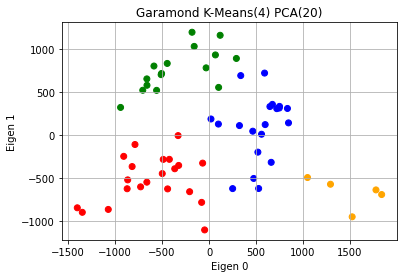

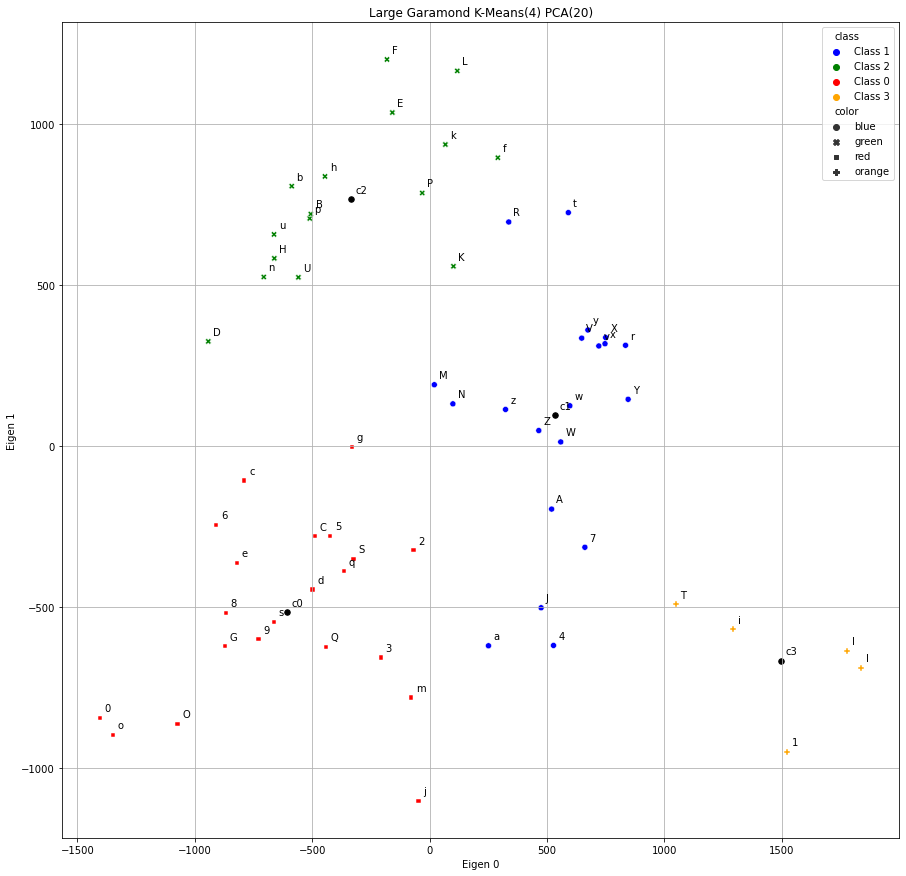

In [101]:
kmeans_results = perform_clustering('kmeans', reduced_df)

small_plot(
    reduced_df, 
    kmeans_results['labels'], 
    'Garamond K-Means(4) PCA(20)'
)

large_plot(
    reduced_df, 
    kmeans_results['labels'], 
    'Large Garamond K-Means(4) PCA(20)',
    ['blue', 'green', 'red', 'orange'],
    kmeans_results['centers']
)

### Spectral Clustering

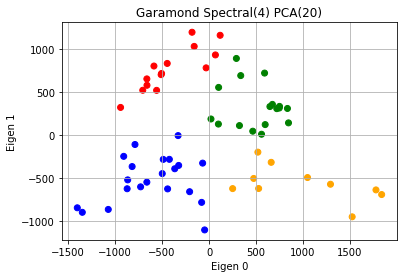

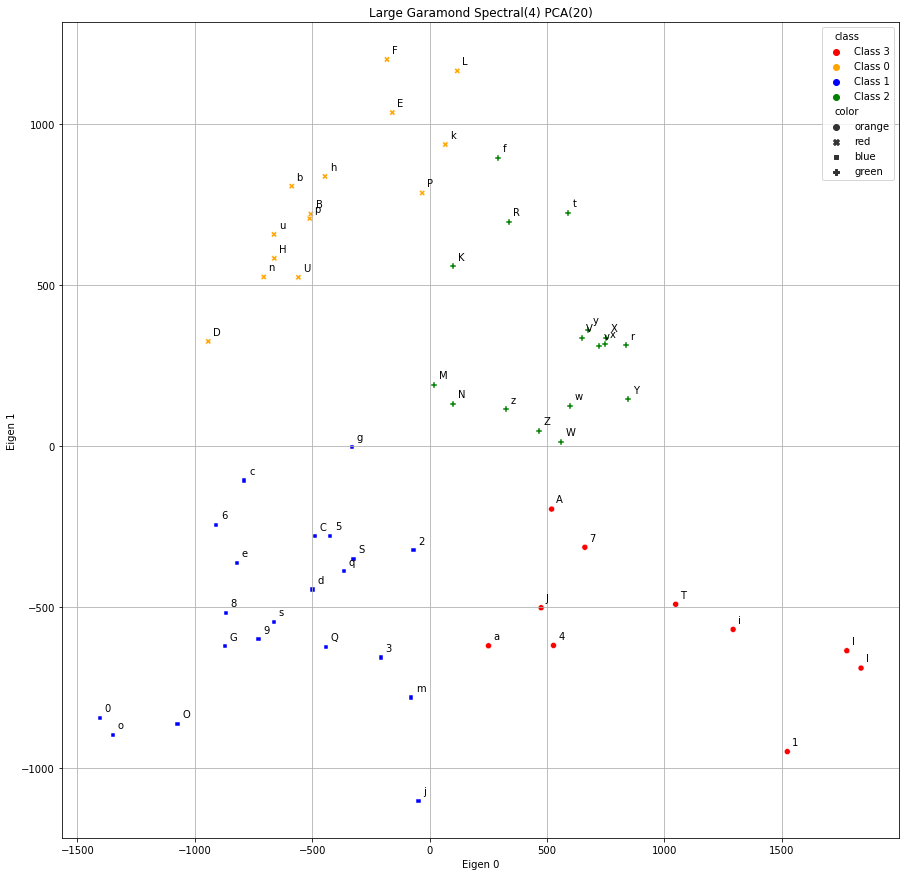

In [104]:
spectral_results = perform_clustering('spectral', reduced_df)

small_plot(
    reduced_df, 
    spectral_results['labels'], 
    'Garamond Spectral(4) PCA(20)'
)

large_plot(
    reduced_df, 
    spectral_results['labels'], 
    'Large Garamond Spectral(4) PCA(20)',
    ['red', 'orange', 'blue', 'green']
)

### Agglomerative Clustering

/home/digital-tenebrist/.conda/envs/math-637/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:247: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


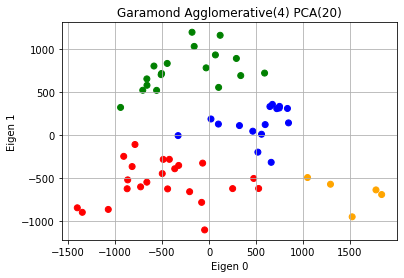

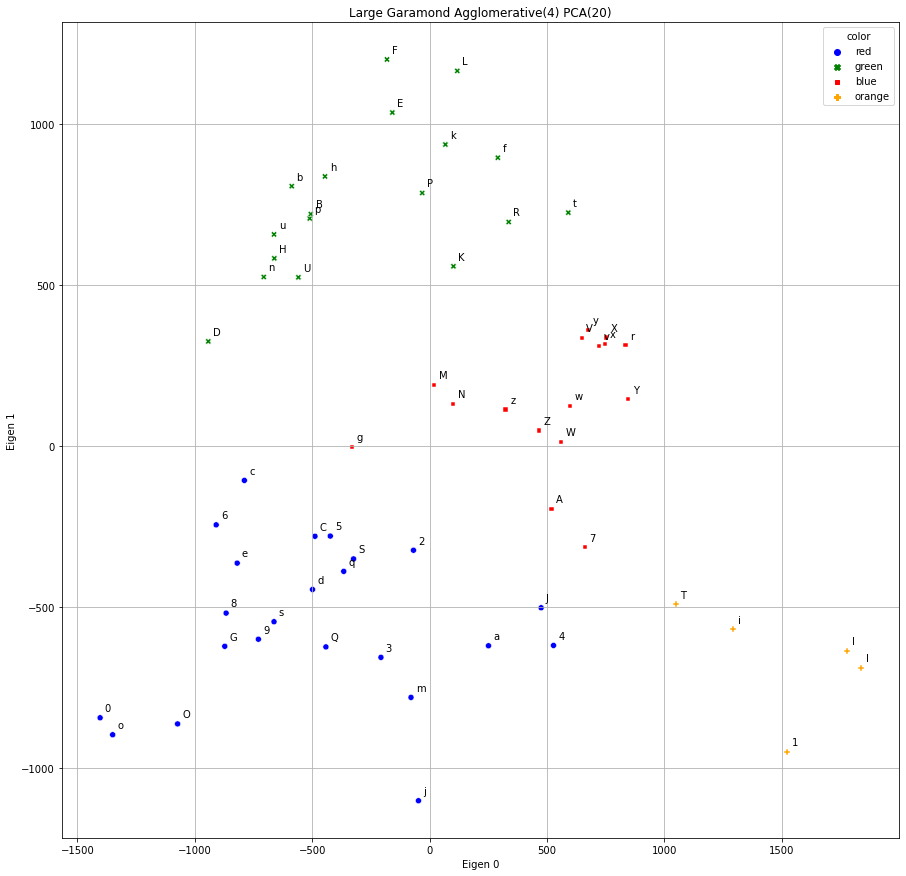

In [93]:
agg_results = perform_clustering('agglomerative', reduced_df)

small_plot(
    reduced_df, 
    agg_results['labels'], 
    'Garamond Agglomerative(4) PCA(20)'
)

large_plot(
    reduced_df, 
    agg_results['labels'], 
    'Large Garamond Agglomerative(4) PCA(20)'
)